<img src="../images/headers/nb_2.svg"  width="1080" height="220">

In this notebook, the data will be visualized and analyzed

# Import Modules and Data

In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from bokeh.models import DatePicker
from bokeh.plotting import show

from roaf import visualization

plt.style.use("dark_background")

In [2]:
df_by_person = pd.read_parquet("../data/processed/df_by_person.parquet")
df_by_accident = pd.read_parquet("../data/processed/df_by_accident.parquet")

# Daytime distribution of accidents

In [3]:
plot_df = pd.DataFrame(
    {
        "is_weekend": df_by_accident["is_weekend"],
        "time": df_by_accident["date"].apply(lambda x: int(x.strftime("%H%M"))),
    }
)

Text(0.5, 1.0, 'Distribution of Accidents by Daytime')

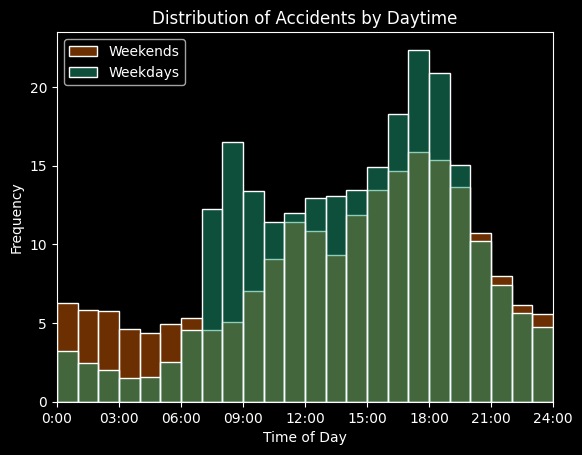

In [4]:
day_time_ticks = (0, 300, 600, 900, 1200, 1500, 1800, 2100, 2400)
day_time_tick_labels = (
    "0:00",
    "03:00",
    "06:00",
    "09:00",
    "12:00",
    "15:00",
    "18:00",
    "21:00",
    "24:00",
)
fig = plt.figure()
plot_df = df_by_accident[["is_weekend", "hhmm"]].astype("int")
weights = plot_df["is_weekend"].apply(lambda x: 0.5 if x == 1 else 0.2)
sns.histplot(
    data=plot_df,
    x="hhmm",
    hue="is_weekend",
    weights=weights,
    stat="frequency",
    bins=24,
    binrange=(0, 2400),
    common_norm=False,
    palette="Dark2",
)
plt.xticks(ticks=day_time_ticks, labels=day_time_tick_labels)
plt.xlabel("Time of Day")
plt.xlim((0, 2400))
plt.legend(["Weekends", "Weekdays"])
plt.title("Distribution of Accidents by Daytime")

# Age, sex, and role in accident

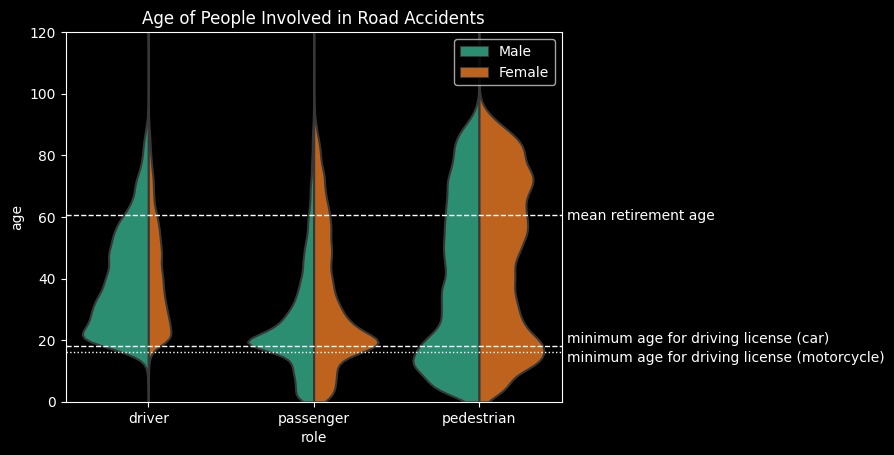

In [5]:
ax = sns.violinplot(
    data=df_by_person,
    x="role",
    y="age",
    hue="sex",
    bw=0.1,
    scale="count",
    split=True,
    palette="Dark2",
    inner=None,
    cut=0,
)
plt.title("Age of People Involved in Road Accidents")
plt.ylim((0, df_by_person["age"].max()))
ax.set_xticklabels(["driver", "passenger", "pedestrian"])


# Add some horizontal lines for important ages
def add_ageline(age, text, linestyle="--", y_offset=-1.5):
    """Plot a horizontal line for a specified age with annotation"""
    plt.axhline(y=age, linestyle=linestyle, linewidth=1)
    plt.annotate(
        text=text, xy=(1.01, age + y_offset), xycoords=("axes fraction", "data")
    )


# Minimum ages for drvinig license
add_ageline(age=18, text="minimum age for driving license (car)", y_offset=1)
add_ageline(
    age=16,
    text="minimum age for driving license (motorcycle)",
    linestyle="dotted",
    y_offset=-3,
)

# People stop working with 60.6 years, according to the
# OECD (https://www.oecd.org/fr/france/PAG2021-FRA.pdf)
add_ageline(age=60.6, text="mean retirement age")

ax.legend(handles=ax.legend_.legend_handles, labels=["Male", "Female"])

The plot shows a huge difference for the sex of drivers involved in accidents.
To interpret this figure correctly, one would need more information about the distribution of
drivers, as men might simply be more often the person who drives.

Another interesting observation is that at higher age, there are virtually no male passengers
involved. A possible explanation is, that men drive themselves while their wives are their
passengers.

I expected to see a greater effect of the retirement age.

It might be important for the understanding that a 'driver' can also simply drive a bike, which
explains the drivers under 16

# Geodata

In [6]:
earliest_date = df_by_accident["date"].min().isoformat()
latest_date = df_by_accident["date"].max().isoformat()
date_picker = DatePicker(
    title="Select Date",
    value=earliest_date,
    min_date=earliest_date,
    max_date=latest_date,
)
picked_date = datetime.fromisoformat(date_picker.value)
show(date_picker)

In [7]:
picked_date = datetime(year=2019, month=11, day=30).date()
visualization.plot_geodata(
    df_by_accident,
    picked_date,
    output_path="../html/map.html",
    n_plot_max=10_000,
    figsize=int(500),
    return_html=False,
)